In [78]:
import copy
import json
import os
import numpy as np
import kernel
import configuration
import calibration
from matplotlib import pyplot as plt

In [79]:
def test_data(c_path, w_path, e_path, json_path, offset=1, printing=True): 
    descriptors = np.loadtxt(c_path)
    weights = np.loadtxt(w_path)
    e_ave = np.loadtxt(e_path)[0]
    with open(json_path, 'r') as u_conf:
            user_config = json.load(u_conf)

    # make a list of the allowed qs
    qs = np.arange(1, user_config['nr_modi']+1) * np.pi / user_config['cutoff']

    # read in data and save parameters for calibration comparison
    (nc_new, ni_new, lat, configurations) = calibration.load_data(user_config, offset)

    config = configurations[0]
    
    if printing:
        for key, value in user_config.items():
            if type(value) != list:
                print(f'{key:>15}: {value:<15}')
            else:
                print(f'{key:>15}: {value[0]:<15}')
                print(f'{"sigma":>15}: {value[1]:<15}')

    nc_old = int(weights.size / 64)
    ni_old = 64

    kern = kernel.Kernel(*user_config['kernel'])

    config.init_nn(user_config['cutoff'], lat)
    config.init_descriptor(qs)

    E, F_reg = kern.predict(qs, config, descriptors, weights, e_ave)
    
    delta_F = F_reg - config.forces
    F_mean = np.mean(np.linalg.norm(delta_F, axis=1))
    F_var = np.var(np.linalg.norm(delta_F, axis=1))

    signs_reg = np.sign(F_reg)
    signs_ana = np.sign(config.forces)
    sign_diff = signs_reg - signs_ana
    
    if printing:
        print('\nPredicted values:')
        print(f'energy = {E}')
        print(f'forces = {F_reg[1]}\n')

        print('Values from Outcar:')
        print(f'energy = {config.energy}')
        print(f'forces = {config.forces[1]}')
        print('\nSign differences:', sign_diff[sign_diff != 0].size, 'out of', sign_diff.size)
        #print(sign_diff)


        print(f'Mean norm of difference:\n {F_mean} +- {F_var}')
        print(f'Relative to size of F:\n {F_mean / np.mean(np.linalg.norm(config.forces, axis=1))}')
    return(F_mean, F_var,  sign_diff[sign_diff != 0].size)



In [80]:
def float_to_str(nr: float):
    return str(nr).replace('.', '')

def min_sigma_of_axis(data, axis):
    return data[np.where(data[:, axis] == np.amin(data[:, axis]))][0]
    
def plot3(data: np.array, max_n, title=""):
    fig, axs = plt.subplots(1, 3, figsize = (20, 5))
    fig.suptitle(title, fontsize=16)
    titles = ["mean", "variance", "sign difference"]
    for i in range(1, 4):
        axs[i-1].plot(data[:max_n, 0], data[:max_n, i])
        axs[i-1].grid()
        axs[i-1].set(xlabel="$\sigma$", title=titles[i-1])
        if i != 3:
            axs[i-1].set_yscale('log')

def analyze(n: int, modi: int, step=0.25, max_n=-1):
    print(f'{"steps":10}={n:5}')
    print(f'{"stepsize":10}={step:5}')
    print(f'{"max sigma":10}={n * step:5}')
    print(f'{"modi":10}={modi:5}\n')

    step_str = float_to_str(step)
    fit = np.loadtxt(f'test_data/fit_{n}-{modi}-{step_str}.dat')
    print('Minimize values in fitting')
    print(f'{"sigma":10}|{"mean":10}|{"var":10}|{"signs":10}|')
    for i in range(1, 4):
        line = ""
        for val in min_sigma_of_axis(fit, i):
            line += f'{val:10.5f}|'
        print(line)
    
    print("\n")
    prediction = np.loadtxt(f'test_data/prediction_{n}-{modi}-{step_str}.dat')
    print('Minimize values in prediction')
    print(f'{"sigma":10}|{"mean":10}|{"var":10}|{"signs":10}|')
    for i in range(1, 4):
        line = ""
        for val in min_sigma_of_axis(prediction, i):
            line += f'{val:10.5f}|'
        print(line)
        
    plot3(fit, max_n, "Fitting")
    plot3(prediction, max_n, "Prediction")

# Linear Kernel

In [81]:
test_data('test_data/c_lin_10.out', 'test_data/w_lin_10.out', 'test_data/e_lin_10.out', 'test_data/lin_10.json')

        file_in: OUTCAR.21      
       file_out: test_data      
       stepsize: 1000           
         cutoff: 4              
        nr_modi: 10             
         lambda: 0.001          
         kernel: linear         
          sigma:                

Predicted values:
energy = -307.3937472587071
forces = [ 0.6930024  -0.21777951 -0.47929145]

Values from Outcar:
energy = -306.56723878
forces = [ 0.463753 -0.593154 -0.339427]

Sign differences: 28 out of 192
Mean norm of difference:
 0.49890646576586417 +- 0.04779279743831686
Relative to size of F:
 0.3724728151966518


(0.49890646576586417, 0.04779279743831686, 28)

# Gaussian Kernel

In [82]:
test_data('test_data/c_gaus_10.out', 'test_data/w_gaus_10.out', 'test_data/e_gaus_10.out', 'test_data/gaus_10.json')     

        file_in: OUTCAR.21      
       file_out: test_data      
       stepsize: 1000           
         cutoff: 4              
        nr_modi: 10             
         lambda: 0.001          
         kernel: gaussian       
          sigma: 1              

Predicted values:
energy = -307.9103162022497
forces = [-32.09861649  -5.30471067 -13.71075235]

Values from Outcar:
energy = -306.56723878
forces = [ 0.463753 -0.593154 -0.339427]

Sign differences: 92 out of 192
Mean norm of difference:
 28.491481832043167 +- 1205.438889367551
Relative to size of F:
 21.271126303834496


(28.491481832043167, 1205.438889367551, 92)

# Bigger sigma

In [83]:
test_data('data/calibration_C.out', 'data/calibration_w.out', 'data/calibration_E.out', 'user_config.json', 0)

        file_in: OUTCAR.21      
       file_out: data           
       stepsize: 100            
         cutoff: 4              
        nr_modi: 12             
         lambda: 1e-12          
         kernel: gaussian       
          sigma: 0.67           

Predicted values:
energy = -306.4166920449692
forces = [ 0.86415965 -1.14949625 -0.65978916]

Values from Outcar:
energy = -306.41169589
forces = [ 0.354149 -0.521376 -0.257292]

Sign differences: 50 out of 192
Mean norm of difference:
 1.0145789299062586 +- 0.2379812034562667
Relative to size of F:
 0.7380530928065789


(1.0145789299062586, 0.2379812034562667, 50)

# Analyzing the influence of $\sigma$ in correspondence to nr of modi

steps     =  200
stepsize  = 0.25
max sigma = 50.0
modi      =   10

Minimize values in fitting
sigma     |mean      |var       |signs     |
   7.50000|   0.33095|   0.01940|  18.00000|
   7.75000|   0.37101|   0.01861|  19.00000|
   7.50000|   0.33095|   0.01940|  18.00000|


Minimize values in prediction
sigma     |mean      |var       |signs     |
   7.50000|   0.37449|   0.02381|  18.00000|
   6.25000|   0.38715|   0.01906|  18.00000|
   5.25000|   0.41314|   0.02500|  16.00000|


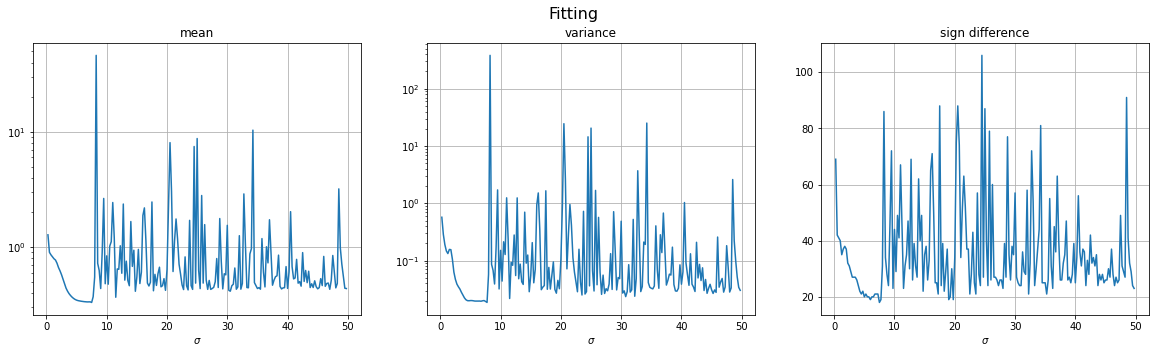

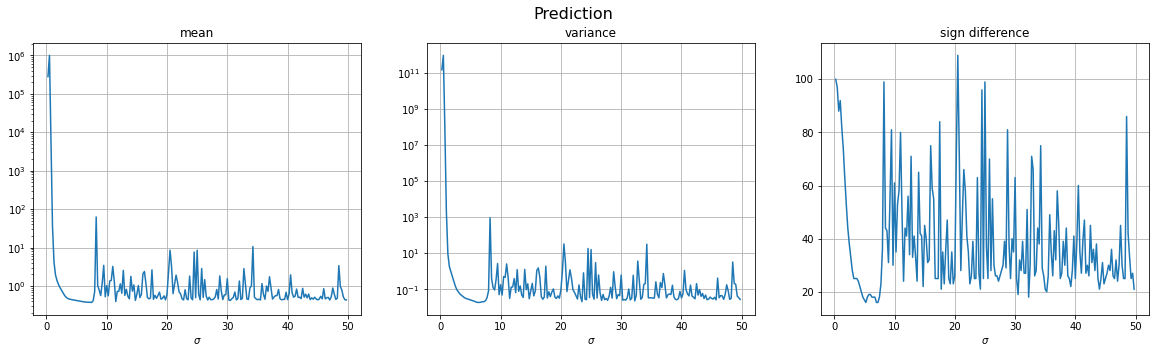

In [90]:
analyze(200, 10, max_n = -1)

steps     =  200
stepsize  = 0.25
max sigma = 50.0
modi      =    8

Minimize values in fitting
sigma     |mean      |var       |signs     |
   3.75000|   0.33839|   0.02119|  20.00000|
   3.00000|   0.36429|   0.01790|  20.00000|
   4.75000|   0.34142|   0.01939|  18.00000|


Minimize values in prediction
sigma     |mean      |var       |signs     |
   4.00000|   0.39891|   0.02430|  22.00000|
   4.75000|   0.39987|   0.02322|  22.00000|
   3.25000|   0.42143|   0.03052|  19.00000|


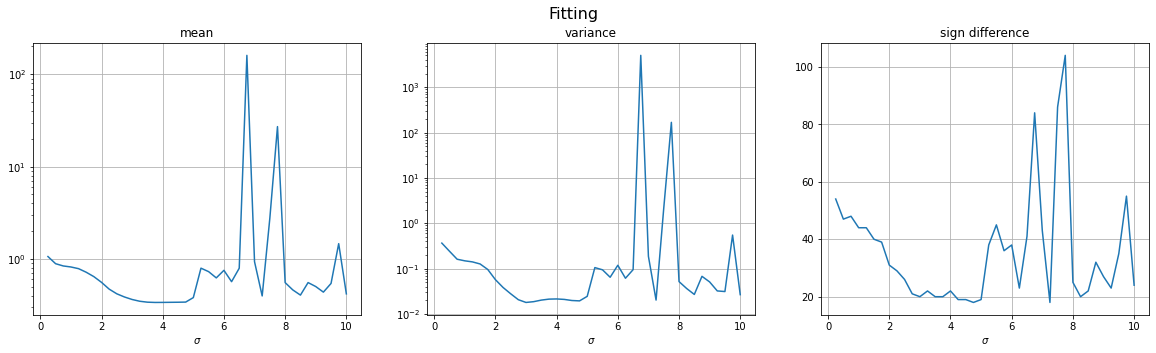

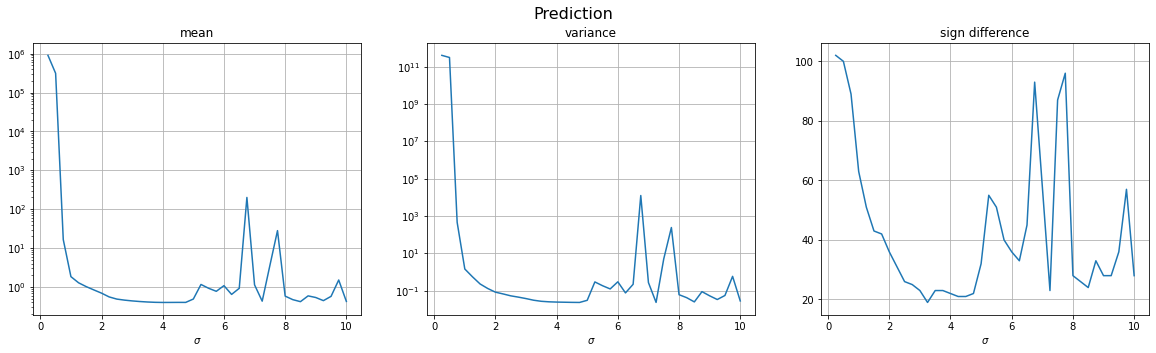

In [85]:
analyze(200, 8, max_n=40)

steps     =  100
stepsize  = 0.25
max sigma = 25.0
modi      =    6

Minimize values in fitting
sigma     |mean      |var       |signs     |
   2.50000|   0.38380|   0.02345|  26.00000|
   2.25000|   0.39105|   0.02309|  26.00000|
  16.50000|   0.42948|   0.03388|  21.00000|


Minimize values in prediction
sigma     |mean      |var       |signs     |
  22.50000|   0.41769|   0.03171|  21.00000|
  11.00000|   0.46799|   0.02233|  24.00000|
  22.50000|   0.41769|   0.03171|  21.00000|


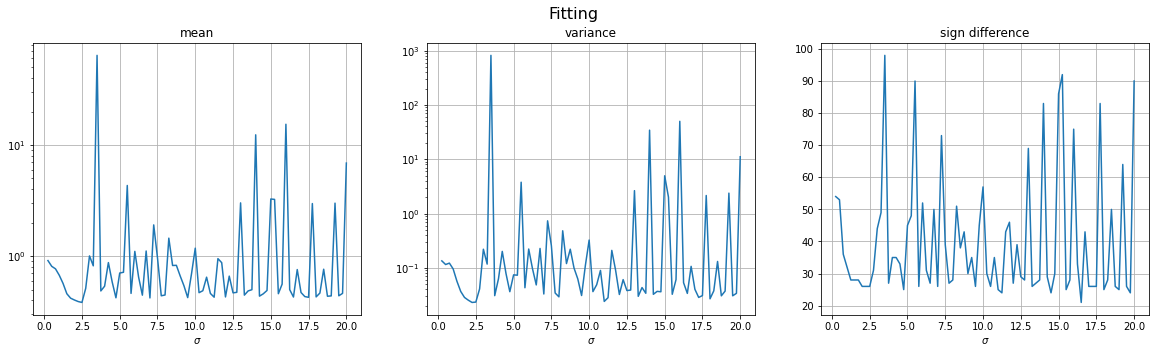

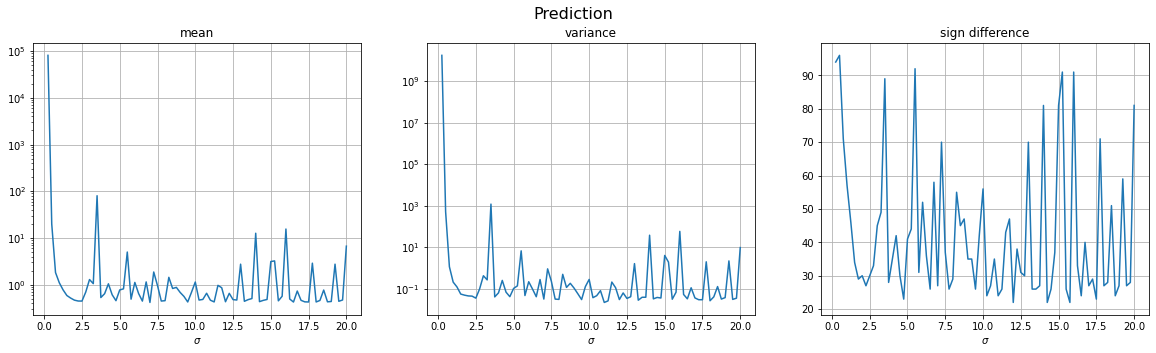

In [86]:
analyze(100, 6, max_n=80)

steps     =  100
stepsize  = 0.25
max sigma = 25.0
modi      =    4

Minimize values in fitting
sigma     |mean      |var       |signs     |
   1.00000|   0.41237|   0.02259|  28.00000|
   1.00000|   0.41237|   0.02259|  28.00000|
  12.50000|   0.50538|   0.05220|  24.00000|


Minimize values in prediction
sigma     |mean      |var       |signs     |
   2.75000|   0.46460|   0.03371|  27.00000|
  10.75000|   0.47948|   0.03326|  28.00000|
   6.25000|   0.49428|   0.04693|  25.00000|


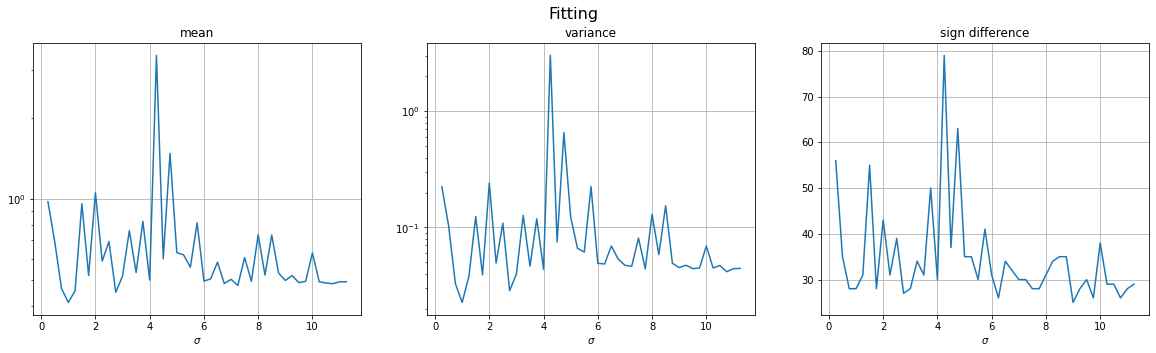

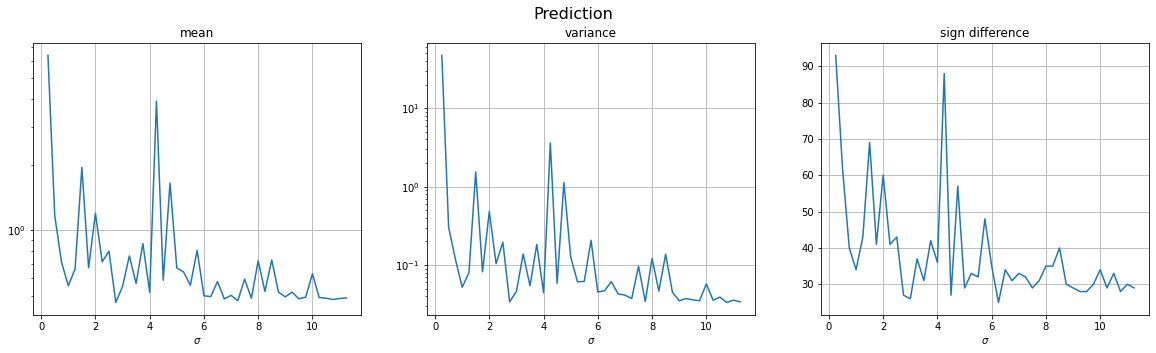

In [87]:
analyze(100, 4, max_n=45)

steps     =  100
stepsize  = 0.25
max sigma = 25.0
modi      =   12

Minimize values in fitting
sigma     |mean      |var       |signs     |
  10.50000|   0.32887|   0.02040|  19.00000|
   7.50000|   0.33450|   0.01670|  18.00000|
   7.25000|   0.33522|   0.01676|  16.00000|


Minimize values in prediction
sigma     |mean      |var       |signs     |
   7.50000|   0.36882|   0.02297|  24.00000|
  24.75000|   0.42389|   0.02245|  26.00000|
   5.25000|   0.42285|   0.03153|  19.00000|


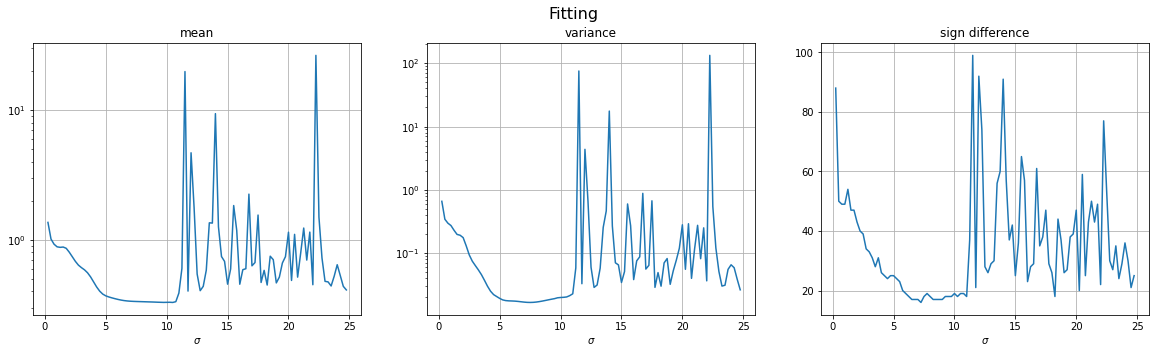

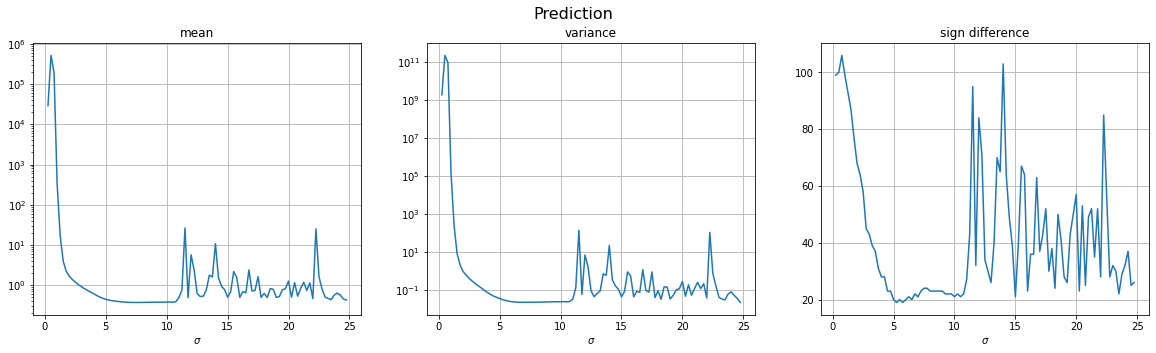

In [88]:
analyze(100, 12)

steps     =  100
stepsize  = 0.01
max sigma =  1.0
modi      =   12

Minimize values in fitting
sigma     |mean      |var       |signs     |
   1.00000|   0.88371|   0.27336|  49.00000|
   1.00000|   0.88371|   0.27336|  49.00000|
   0.73000|   0.93069|   0.29753|  47.00000|


Minimize values in prediction
sigma     |mean      |var       |signs     |
   0.12000|   1.33916|   0.51470| 110.00000|
   0.13000|   1.34143|   0.50857|  90.00000|
   0.04000|   1.33944|   0.51535|  75.00000|


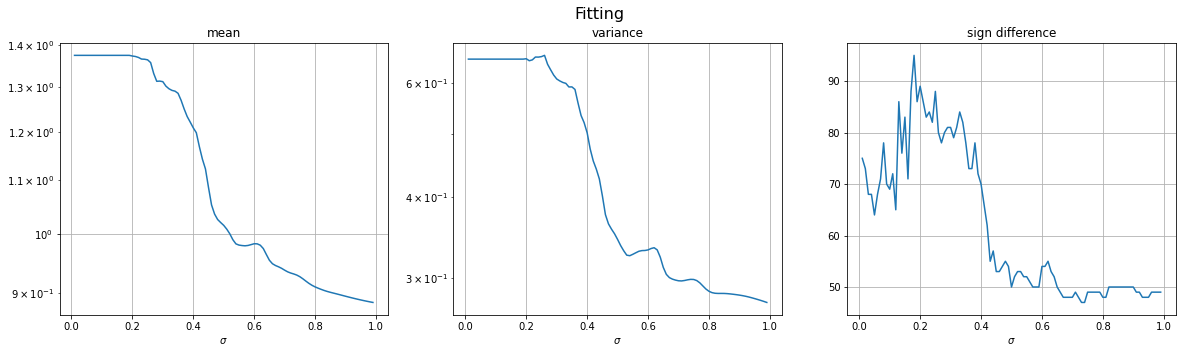

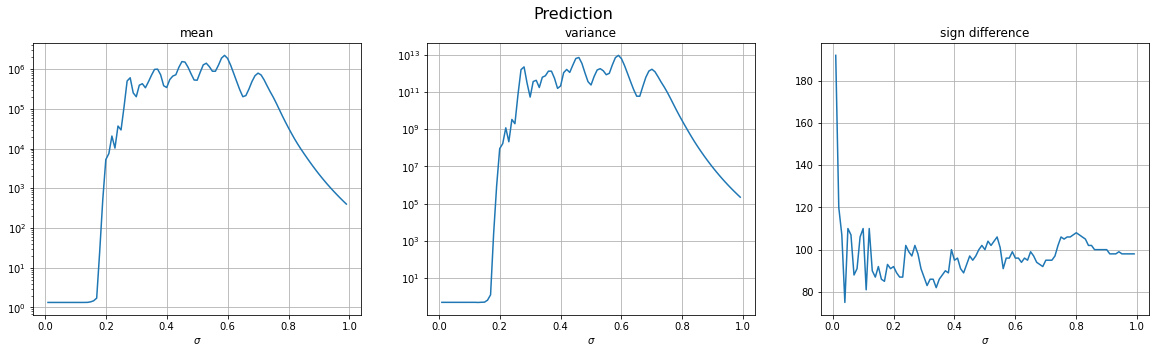

In [89]:
analyze(100, 12, 0.01)

steps     =  100
stepsize  = 0.01
max sigma =  1.0
modi      =   10

Minimize values in fitting
sigma     |mean      |var       |signs     |
   1.00000|   0.82294|   0.14754|  40.00000|
   1.00000|   0.82294|   0.14754|  40.00000|
   0.84000|   0.84760|   0.17043|  39.00000|


Minimize values in prediction
sigma     |mean      |var       |signs     |
   0.10000|   1.32476|   0.52509|  89.00000|
   0.09000|   1.35309|   0.51056| 109.00000|
   0.37000|575556.92496|652613572035.82666|  83.00000|


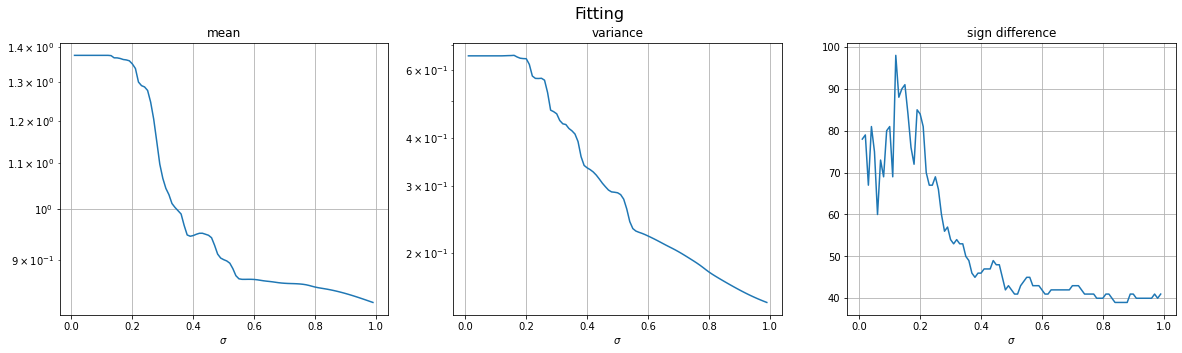

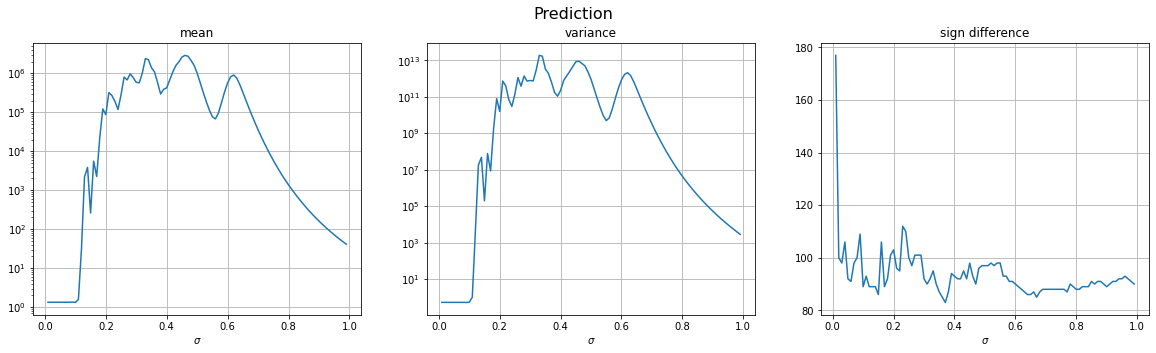

In [91]:
    analyze(100, 10, 0.01)

steps     =  100
stepsize  =0.0001
max sigma = 0.01
modi      =   10

Minimize values in fitting
sigma     |mean      |var       |signs     |
   0.00010|   1.10258|   0.27390|  63.00000|
   0.00010|   1.10258|   0.27390|  63.00000|
   0.00540|   1.37467|   0.65397|  51.00000|


Minimize values in prediction
sigma     |mean      |var       |signs     |
   0.00010|   1.33944|   0.51535| 192.00000|
   0.00010|   1.33944|   0.51535| 192.00000|
   0.00970|   1.33944|   0.51535| 175.00000|


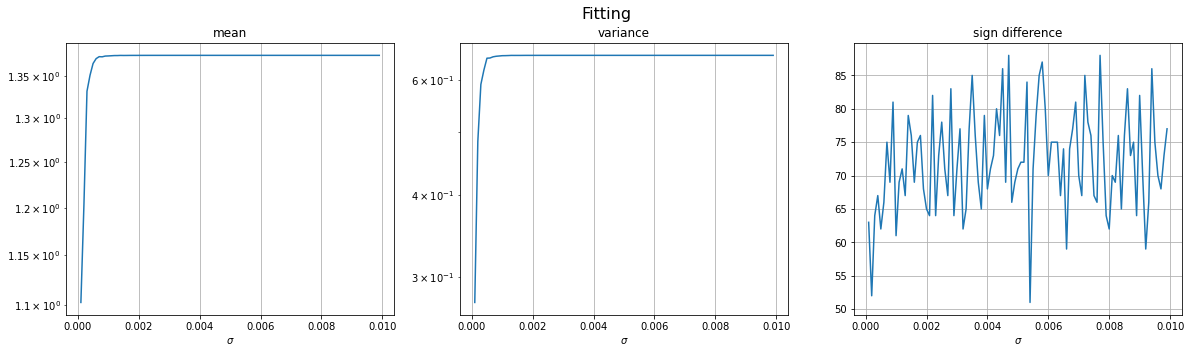

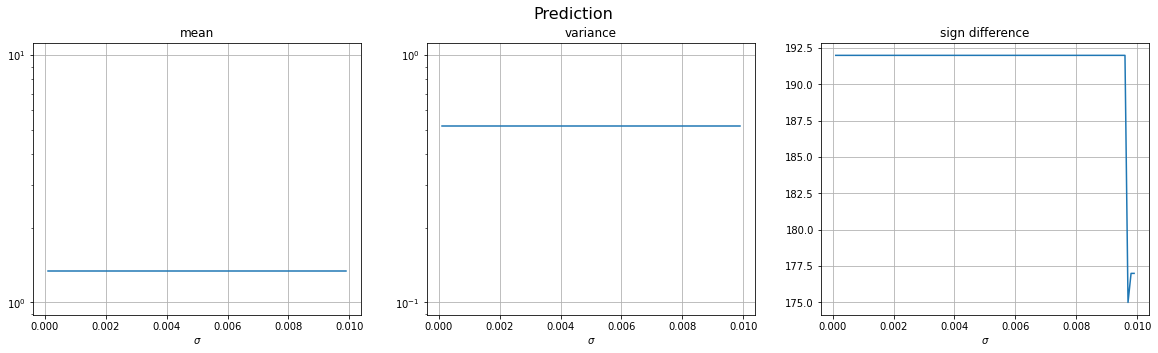

In [92]:
analyze(100, 10, 0.0001)

steps     =  100
stepsize  =1e-06
max sigma =9.999999999999999e-05
modi      =   10

Minimize values in fitting
sigma     |mean      |var       |signs     |
   0.00005|   1.03763|   0.19047|  52.00000|
   0.00005|   1.03763|   0.19047|  52.00000|
   0.00002|   1.16759|   0.33923|  48.00000|


Minimize values in prediction
sigma     |mean      |var       |signs     |
   0.00000|   1.33944|   0.51535| 192.00000|
   0.00000|   1.33944|   0.51535| 192.00000|
   0.00000|   1.33944|   0.51535| 192.00000|


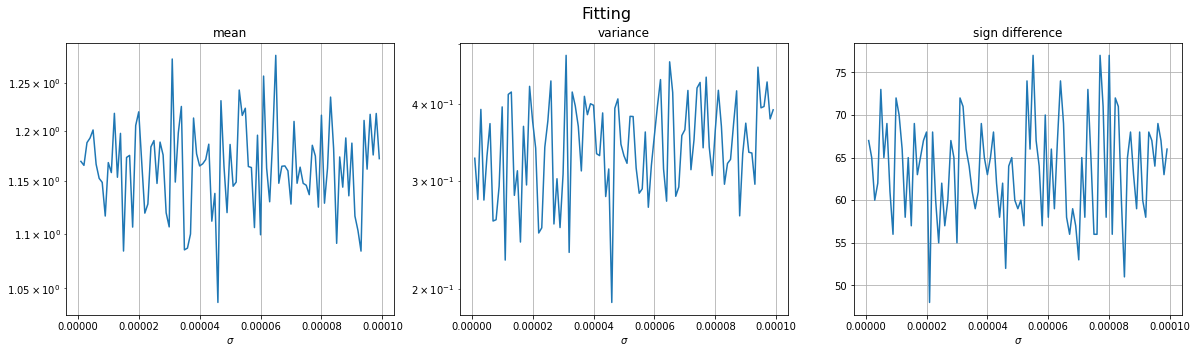

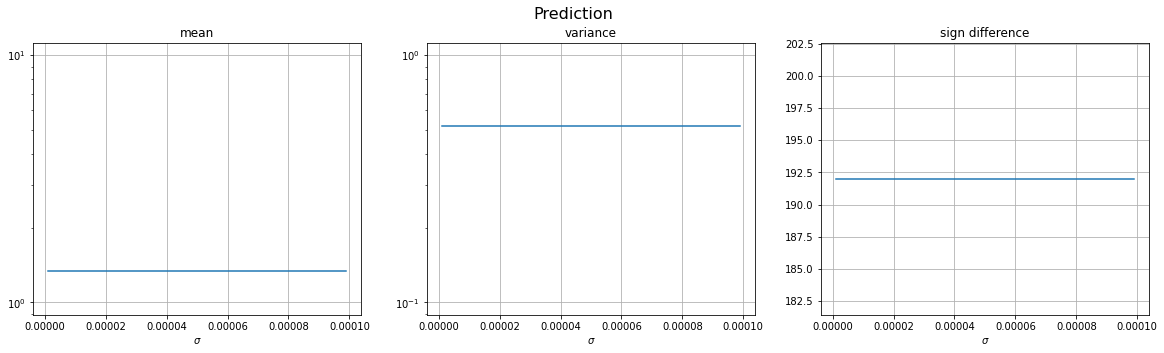

In [93]:
analyze(100, 10, 0.000001)